## Практическое задание

<ol>
    <li>Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

    
<li>*Попробуйте на numpy реализовать нейронную сеть архитектуры LSTM</li>
<li>*Предложите свои варианты решения проблемы исчезающего градиента в RNN</li>
</ol>

In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
import datetime

In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)


In [3]:
numpy.random.seed(7)

In [4]:
dataframe = pd.read_csv('airline-passengers.csv', usecols=[1], engine='python')

In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 1.2 KB


In [6]:
dataframe.isnull().sum()

Passengers    0
dtype: int64

In [7]:
dataframe.head()

,Passengers
0,112
1,118
2,132
3,129
4,121


In [8]:
dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


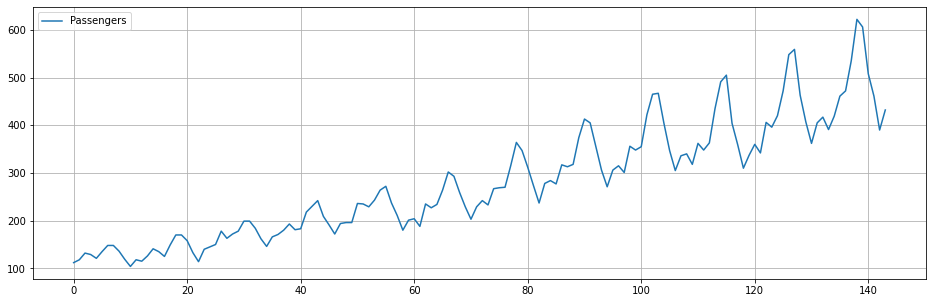

In [9]:
dataframe.plot( figsize = (16,5))
plt.grid('On')
plt.show()

Визуально наблюдаем рост пассажиропотока на фоне периодических колебаний (предположительно сезонных)

In [10]:
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [11]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [12]:
look_back = 3

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

Посмотрим на распределение данных для теста и трейна

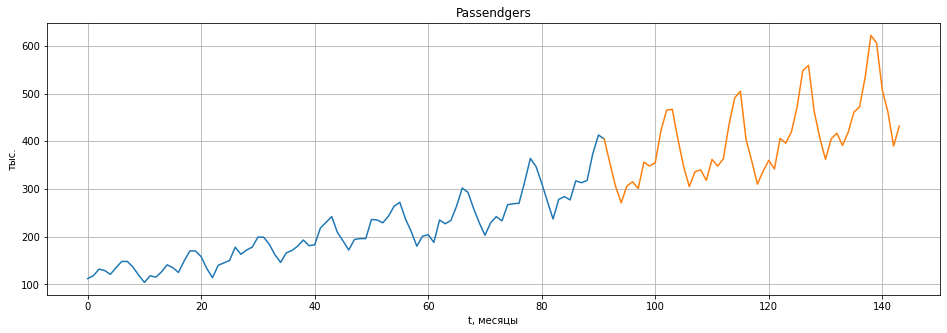

In [13]:
plt.figure(figsize=(16,5))
plt.plot(dataframe[0:92])
plt.plot(dataframe[91:144])
plt.grid('on')
plt.xlabel('t, месяцы')
plt.ylabel('тыс.')
plt.title('Passendgers')
plt.show()

Построим Модель 1

In [14]:
batch_size = 1

model1 = Sequential()
model1.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')

2022-06-08 11:28:02.505915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
for i in range(100):
    model1.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model1.reset_states()

92/92 - 1s - loss: 0.0047 - 1s/epoch - 15ms/step
92/92 - 0s - loss: 0.0074 - 118ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0057 - 113ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0048 - 106ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0045 - 115ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0044 - 111ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0044 - 113ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0043 - 102ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0043 - 117ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0042 - 112ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0041 - 112ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0041 - 111ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0040 - 105ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0039 - 112ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0038 - 110ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0038 - 115ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0037 - 110ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0036 - 103ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0035 - 117ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0034 - 106ms

In [16]:
trainPredict = model1.predict(trainX, batch_size=batch_size)
model1.reset_states()
testPredict = model1.predict(testX, batch_size=batch_size)

44/44 [==============================] - 0s 938us/step


In [17]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [18]:
trainPredictPlot1 = numpy.empty_like(dataset)
trainPredictPlot1[:, :] = numpy.nan
trainPredictPlot1[look_back:len(trainPredict)+look_back, :] = trainPredict

In [19]:
testPredictPlot1 = numpy.empty_like(dataset)
testPredictPlot1[:, :] = numpy.nan
testPredictPlot1[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

In [20]:
trainScore1 = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore1 = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

Построим Модель 2

In [21]:
look_back = 3

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

batch_size = 1

model2 = Sequential()
model2.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))

model2.add(Flatten())                      
#model2.add(Dense(8, activation="linear"))

model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')

In [22]:
for i in range(100):
    model2.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model2.reset_states()

92/92 - 1s - loss: 0.0214 - 1s/epoch - 15ms/step
92/92 - 0s - loss: 0.0248 - 114ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0190 - 117ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0159 - 119ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0133 - 118ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0108 - 117ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0087 - 116ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0070 - 117ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0060 - 117ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0054 - 116ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0051 - 118ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0049 - 121ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0048 - 123ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0048 - 116ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0047 - 118ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0047 - 124ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0046 - 104ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0046 - 100ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0046 - 88ms/epoch - 959us/step
92/92 - 0s - loss: 0.0045 - 96ms

In [23]:
trainPredict = model2.predict(trainX, batch_size=batch_size)
model2.reset_states()
testPredict = model2.predict(testX, batch_size=batch_size)

44/44 [==============================] - 0s 1ms/step


In [24]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [25]:
trainPredictPlot2 = numpy.empty_like(dataset)
trainPredictPlot2[:, :] = numpy.nan
trainPredictPlot2[look_back:len(trainPredict)+look_back, :] = trainPredict

In [26]:
testPredictPlot2 = numpy.empty_like(dataset)
testPredictPlot2[:, :] = numpy.nan
testPredictPlot2[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

In [27]:
trainScore2 = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore2 = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

Визуализируем данные

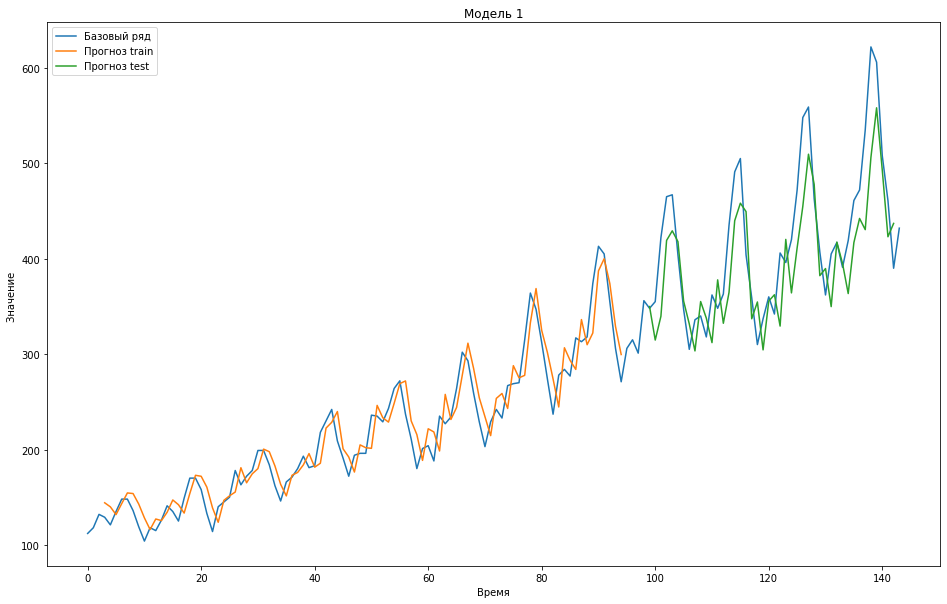

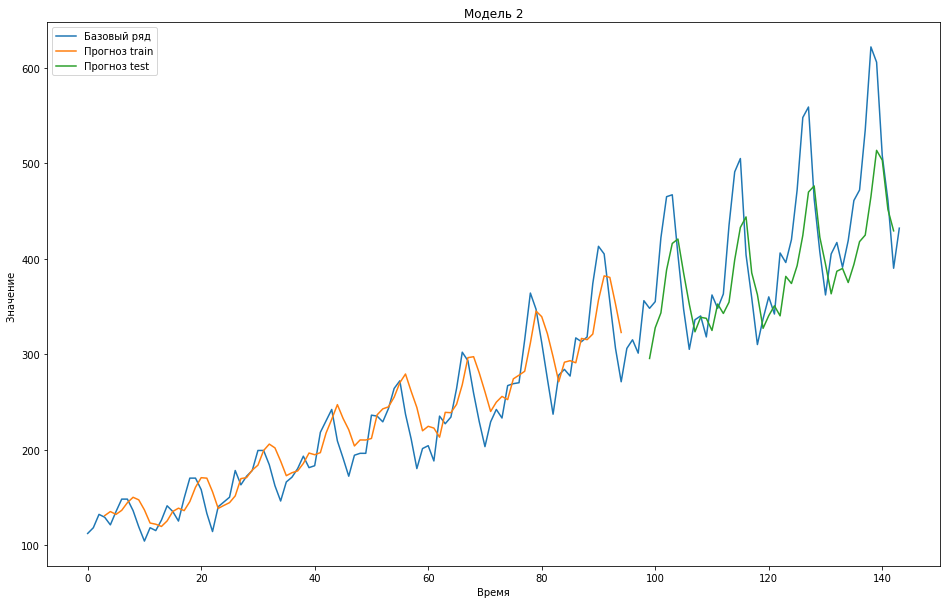

In [28]:
plt.figure(figsize=(16,10))

plt.plot(scaler.inverse_transform(dataset), label='Базовый ряд')
plt.plot(trainPredictPlot1, label='Прогноз train')
plt.plot(testPredictPlot1, label='Прогноз test')
plt.xlabel('Время')
plt.ylabel('Значение ')
plt.title('Модель 1')
plt.legend()
plt.show()
plt.figure(figsize=(16,10))


plt.plot(scaler.inverse_transform(dataset), label='Базовый ряд')
plt.plot(trainPredictPlot2, label='Прогноз train')
plt.plot(testPredictPlot2, label='Прогноз test')
plt.xlabel('Время')
plt.ylabel('Значение ')
plt.title('Модель 2')
plt.legend()
plt.show()

Добавление слоя Flatten в модель, позволило улучшить показатели модели.<br>


In [29]:
print('Модель 1')
print('Train Score: %.2f RMSE' % (trainScore1))
print('Test Score: %.2f RMSE' % (testScore1))

print('Модель 2')
print('Train Score: %.2f RMSE' % (trainScore2))
print('Test Score: %.2f RMSE' % (testScore2))

Модель 1
Train Score: 20.53 RMSE
Test Score: 47.72 RMSE
Модель 2
Train Score: 26.46 RMSE
Test Score: 57.80 RMSE


При этом следует заметить, что добавление еще одного слоя Dense (закоментированного в коде) ведет к переобучению модели на трейне и ухудшению результата на тесте